In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from scipy.interpolate import interp1d 

%matplotlib inline

# Applied Statistics in Solar Energy: Invest on P90.

This post goes through the underpinnings of Exceedance Probabilities and the benefit solar energy developers and enthusiasts alike stand by knowing the basics.

Exceedance Probabilities in the context of solar energy are also referred to as P50/P90 analysis or simply, P values. Among banks and investment firms it's the staple statistical method to determine the economic risk associated with solar resource uncertainty.

Objectively, a P50/P90 analysis determines the likelihood that a solar plant will yield an specific amount of energy (ie. dollars) during any given year of its life. For this reason, exceedance probabilities are paramount for a solar project to a) secure competitive financing and, b) manage operational costs and debt obligations.

So, what exactly are they?

### P as in Percentile

P values refer to the probability that a certain value will be exceeded.
For example, a P90 value of 100, means there is a 90% probability of exceeding 100.

In our context, a P90 of 100 is the likelihood that a solar plant will yield more than 100 units of energy.

Pro-tip: Notice P90 is NOT a 90% probability of producing 100, but of exceeding 100 units (subtle yet very different meaning and a common misunderstanding).

### Methodologies to calculate P values

Dealing with 'uncertainty' and 'statistical methods' may sound intimidating, but once we clear out a few concepts it should be straight forward to grasp.

#### Inputs and High Level

To calculate statistically robust P values of energy estimates we need two inputs:

      1) A long-term historical weather dataset: Using multi-year data assures considering potential worst-case scenarios that could affect a project financial terms.

      2) Performance system modeling: An hourly simulation of the system performance for every single year in the dataset provides the detailed expectations of a system output.

All else equal, yearly outputs are mainly driven by the weather conditions at the project's site. Let's not forget, the goal is to understand that variability and determine the asset expectations on a year-to-year basis.

From an statistics standpoint, we do this by fitting the historical dataset to a function we understand in order to make inferences from it.

In other words, we calculate P values through a two step process:

      1) Fit the previously simulated yearly plant outputs to a distribution function and,

      2) Calculate a desired P value derived from the function properties.


### Example

Consider a fictional 10 MW utility-scale plant somewhere in California.

I've simulated yearly energy outputs for a 1998-2015 dataset at the site, see results in the following table:


In [2]:
sns.set_style('white')

df = pd.read_csv('data/Timeseries_Fictional_Plant.csv')

df.index = pd.DatetimeIndex(df.Datetime)

df['Year'] = df.index.year

df.drop('Datetime', axis=1, inplace = True)

df['POA'] = df.GHI * 1.15

dc = 10000 # Capacity DC -- 10MW 
pr = 0.79 # Fictional Performance Ratio
G = 1000 #constant (W / m2)

df['Output'] = df.POA * dc * pr / G

yearly_production = df.groupby('Year').sum()

yearly_production['Yield'] = yearly_production.Output / dc

yearly_production['Energy Output [GWh]'] = yearly_production.Output / 1000000

df1 = yearly_production['Energy Output [GWh]'].to_frame()

In [3]:
df1['Energy Output [GWh]'].round(2).to_frame().T

Year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Energy Output [GWh],16.62,17.87,17.66,17.95,17.96,17.49,17.94,17.41,17.6,18.12,18.15,17.87,17.29,17.71,18.28,18.38,18.39,18.03


Plotting a histogram will show how the energy outputs are distributed, or, the density of our sample.

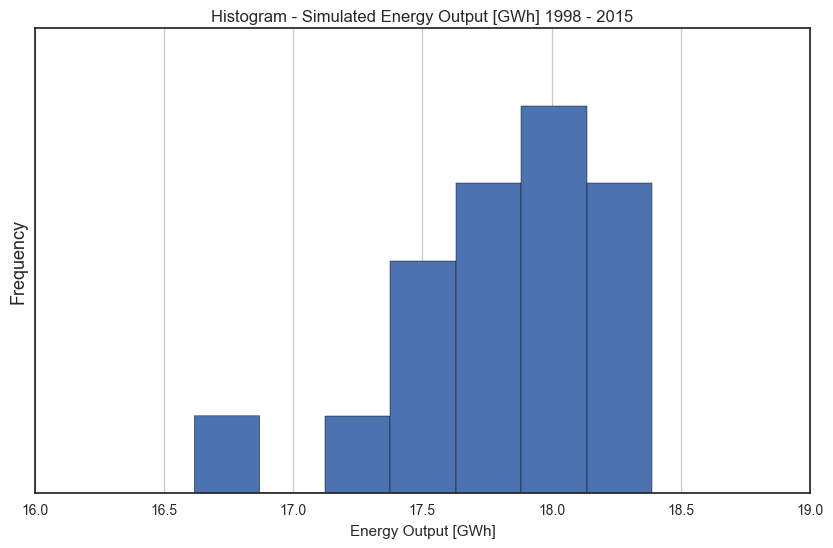

In [4]:
#Potting a histogram.
#Create axis and figure
fig_hist , ax_hist = plt.subplots(1,1)
#Figure Size
fig_hist.set_size_inches(10,6)
#Plot Histogram
df1.hist(bins = 7, ax=ax_hist)
plt.ylim(0,6)
plt.xlim(16, 19)
#Create Labels
plt.ylabel('Frequency', fontsize = 13)
plt.title('Histogram - Simulated Energy Output [GWh] 1998 - 2015')
#Erase yticks
plt.yticks([])
plt.xlabel('Energy Output [GWh]')


The most typical path going forward is to assume the data follows a Normal Probability Distribution (see Wikipedia) and to calculate Cumulative Form (the integral). This is a nice idea if the data was normally distributed, however, that's arguably not the case with the solar resource.

Across a 20-30 year life of a solar project, outlier events such as cyclic weather patterns or volcanic eruptions may skew the data (in our example we potentially have one!).

An alternative approach is to not assume any particular distribution and build one directly from the data. Particularly, we want to build an Empirical Cumulative Density Function.

For illustration purposes, I will calculate the Exceedance Probabilities with both methods and expose why understanding the difference matters.


Let's assume we are using the standard distribution first.
This approach is simple since we know what the function looks like (see Wikipedia). Note it takes two parameters to model, the Mean and Standard Deviation of the dataset.

In [5]:
mean = df1.mean().values[0]
std = df1.std().values[0]

print
print 'Mean of Dataset: {0:.2f}'.format(mean)
print 
print 'Standard Deviation of Dataset: {0:.2f}'.format(std)
print


Mean of Dataset: 17.82

Standard Deviation of Dataset: 0.44



For our hypothetical plant, this is what it looks like with the calculated mean and variance.

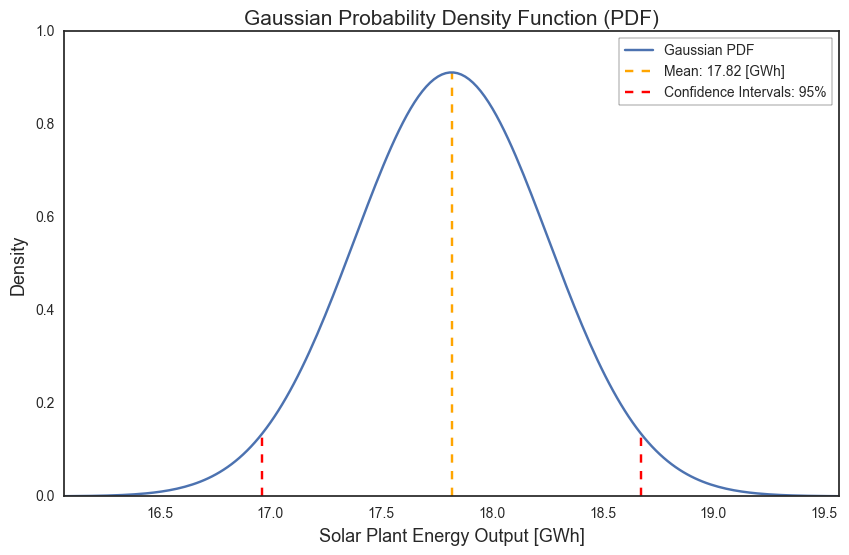

In [6]:
#Create Figure and Axis. 
fig , ax1 = plt.subplots(1,1)
fig.set_size_inches(10,6)
#Compute range values
x_min = mean - std * 4
x_max = mean + std * 4

#Create range array
x1 = np.linspace(x_min, x_max, 200)

#Define mean and std as input parameters for function.
loc1 = mean
scale1 = std

#Fit function to parameters
normal = sts.norm(loc = loc1, scale = scale1)

#Evaluate function with X-range
y_pdf = normal.pdf(x1)

#Plot Gaussian Probability Density Function 
ax1.plot(x1, y_pdf, label = 'Gaussian PDF')

#Plot mean as vertical curve
ax1.vlines(x = loc1, ymin=0, ymax=normal.pdf(loc1), linestyles='--', colors='orange', label = 'Mean: {0:.2f} [GWh]'.format(loc1))
#Plot 95% Confidence Interval
tolerance = 0.05

low_bound = normal.ppf(tolerance/2)
upper_bound = normal.ppf(1 - (tolerance/2))

ax1.vlines(x = low_bound, ymin=0, ymax= normal.pdf(low_bound), linestyles='--', colors='red', label = 'Confidence Intervals: 95%')
ax1.vlines(x = upper_bound, ymin=0, ymax=normal.pdf(upper_bound), linestyles='--', colors='red')

#Define the xrange to show for formatting.
plt.xlim(x_min, x_max)
plt.ylabel('Density', fontsize=13)

plt.title('Gaussian Probability Density Function (PDF)', fontsize = 15)
plt.xlabel('Solar Plant Energy Output [GWh]', fontsize=13)
plt.legend(fontsize = 10, frameon=True)

### The integral of this curve is the cumulative density function -- what we are interested in.

<function matplotlib.artist.getp>

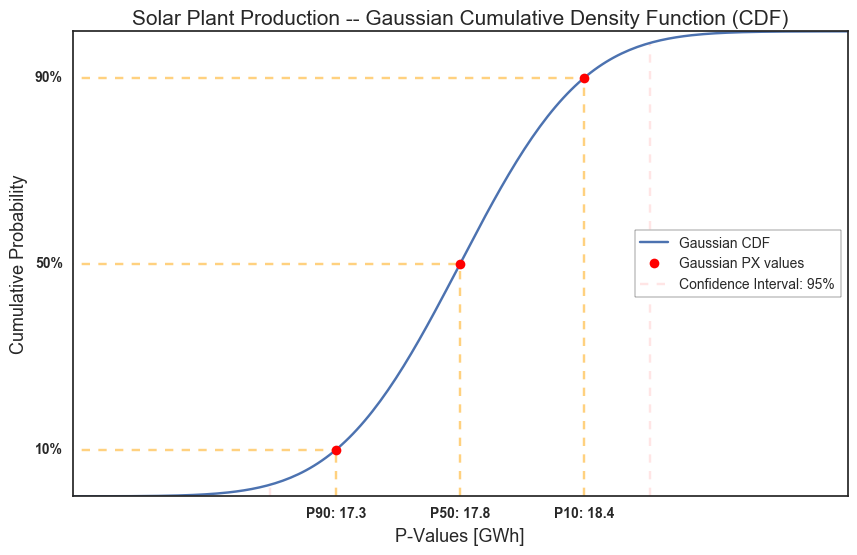

In [14]:
#Create Figure and Axis. 
fig , ax1 = plt.subplots(1,1)
fig.set_size_inches(10,6)

y_cdf = normal.cdf(x1)

#Plot Gaussian Probability Density Function 
ax1.plot(x1, y_cdf, label = 'Gaussian CDF')

#Define P10-P50-P90 values
P90 = normal.ppf(0.1)
P50 = normal.ppf(0.5)
P10 = normal.ppf(0.9)

#PLOT POINTS TO IDENTIFY P-VALUES
ax1.plot([P90, P50, P10],[0.1, 0.5, 0.9], 'o', c= 'red', label = 'Gaussian PX values')

#Plot sample P-values for intructional purposes.
pvals = [(P90,'P90'), (P50,'P50'), (P10,'P10')]
x_ticks = [x for (x,_) in pvals]
x_labels = ['{0}: {1:0.1f}'.format(pvals[i][1],pvals[i][0]) for i, _ in enumerate(pvals)]

y_ticks = [0.1, 0.5, 0.9]
y_labels = ['{0:.0%}'.format(_) for _ in y_ticks]


#Plot P50-P90-P10 as vertical curve
ax1.vlines(x = loc1, ymin=0, ymax=normal.cdf(loc1), linestyles='--', colors='orange', alpha = 0.5)
ax1.vlines(x = P90, ymin=0, ymax = normal.cdf(P90), linestyles='--', colors='orange', alpha = 0.5)
ax1.vlines(x = P10, ymin=0, ymax = normal.cdf(P10), linestyles='--', colors ='orange', alpha = 0.5)

#Plot P50-P90-P10 as horizontal curve
ax1.hlines(y = normal.cdf(loc1), xmin=0, xmax=loc1, linestyles='--', colors='orange', alpha = 0.5)
ax1.hlines(y = normal.cdf(P90), xmin=0, xmax = P90, linestyles='--', colors='orange', alpha = 0.5)
ax1.hlines(y = normal.cdf(P10), xmin=0, xmax = P10, linestyles='--', colors ='orange', alpha = 0.5)

#Plot 95% Confidence Interval
ax1.vlines(x = low_bound, ymin=0, ymax= normal.cdf(low_bound), linestyles='--', colors='red', alpha = 0.1, label = 'Confidence Interval: 95%')
ax1.vlines(x = upper_bound, ymin=0, ymax=normal.cdf(upper_bound), linestyles='--', alpha = 0.1, colors='red')

#Define the xrange to show for formatting.
plt.xlim(x_min, x_max)
plt.ylabel('Cumulative Probability', fontsize=13)
plt.title('Solar Plant Production -- Gaussian Cumulative Density Function (CDF)', fontsize = 15)
plt.xlabel('P-Values [GWh]', fontsize=13)

plt.xticks(x_ticks, x_labels, weight = 'bold')
plt.yticks(y_ticks, y_labels, weight = 'bold')


plt.legend(fontsize = 10, loc =5, frameon=True)
plt.get

To interpret this plot, take the P10 value, it reads:
'The likelihood that the plant will yield more than 18.4 GWh is 10%'.

That's it! We can solve the function to get the proportion of the population (probability) that is greater than any value P.

Let's stop and think about this further.

If you were to invest on a solar plant with minimal risk exposure, would you want to calculate your Return of Investment using a high or low P value?

To answer that, notice a P10 value means that the proportion of yearly simulations where the outcome exceeds such value is only 10%. Another way to think about it is that, a P value is inversely proportional to the expected production.

For example a high probability of exceedance, ie. P90, will reference a relatively low production yield. And the reverse is true for low P values.

That is why Financial Institutions and Plant Owners, on both their best interests would plan according to at least the P50 (which is the expected value or mean); the latter makes sure they service debt obligations and manage operational costs, while the former reduces risk of borrower's default.


### Empirical CDF

Now, let's take a look to the Empirical procedure.

Take our hypothetical plant and dataset, there are 18 years, 18 production values.

Each value constitutes an equal contribution of the total probability or 1 / 18.

Since the distribution is cumulative, we want to sort the values (lowest to highest), and do a cumulative sum of the total contribution at each consecutive data point. The procedure is shown below:


In [8]:
### Calculate cumulative function
df_empirical = df1

#Sort by value lowest - highest.
df_empirical.sort_values(by='Energy Output [GWh]', inplace=True)

#Assign equal probability to each event.
df_empirical['Prob'] = 1./df1.shape[0]

#Calculate cumulative probability.
df_empirical['cumsum'] = df_empirical.Prob.cumsum()

# Define variables for plot.
x_empirical = df_empirical['Energy Output [GWh]'].values
y_empirical = df_empirical['cumsum'].values

In [9]:
df_empirical

,Energy Output [GWh],Prob,cumsum
Year,,,
1998,16.616828,0.055556,0.055556
2010,17.286320,0.055556,0.111111
2005,17.406996,0.055556,0.166667
2003,17.486454,0.055556,0.222222
2006,17.597609,0.055556,0.277778
2000,17.663284,0.055556,0.333333
2011,17.712516,0.055556,0.388889
2009,17.866143,0.055556,0.444444
1999,17.874383,0.055556,0.500000


### With that, we are ready to plot.

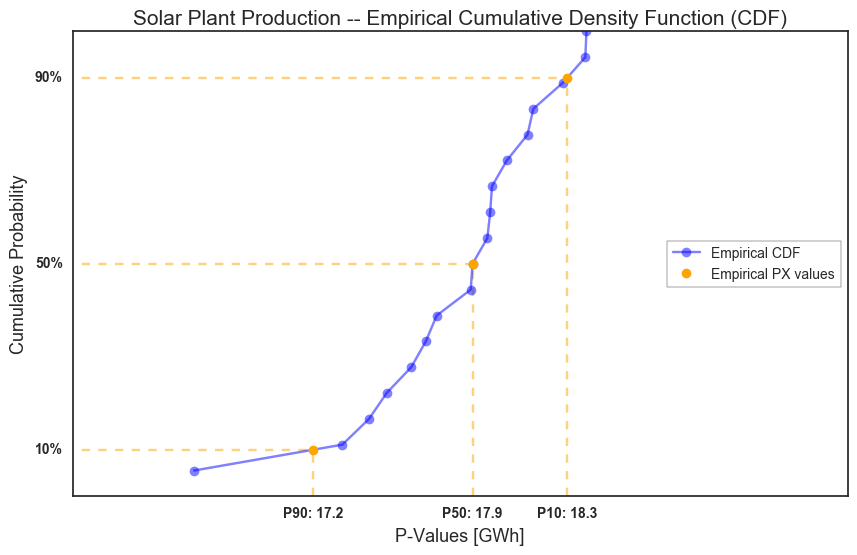

In [16]:
#Create Figure and Axis. 
fig , ax1 = plt.subplots(1,1)
fig.set_size_inches(10,6)

#Plot Gaussian Probability Density Function 
ax1.plot(x_empirical, y_empirical, '-bo', label = 'Empirical CDF', c = 'BLUE', alpha=0.5)
y_interp = interp1d(x = df_empirical['cumsum'], y = df_empirical['Energy Output [GWh]'])

#Define P10-P50-P90 values
P90 = float(y_interp(0.1))
P50 = float(y_interp(0.5))
P10 = float(y_interp(0.9))

#PLOT points over PX Values.

ax1.plot([P90, P50, P10],[0.1, 0.5, 0.9], 'o', c= 'orange', label = 'Empirical PX values')

#Plot sample P-values for intructional purposes.
empirical_pvals = [(P90,'P90'), (P50,'P50'), (P10,'P10')]
x_ticks = [x for (x,_) in empirical_pvals]
x_labels = ['{0}: {1:0.1f}'.format(empirical_pvals[i][1],empirical_pvals[i][0]) for i, _ in enumerate(empirical_pvals)]
y_ticks = [0.1, 0.5, 0.9]
y_labels = ['{0:.0%}'.format(_) for _ in y_ticks]

#Plot P50-P90-P10 as vertical curve
ax1.vlines(x = P50, ymin=0, ymax=0.5, linestyles='--', colors='orange', alpha = 0.5)
ax1.vlines(x = P90, ymin=0, ymax = 0.1, linestyles='--', colors='orange', alpha = 0.5)
ax1.vlines(x = P10, ymin=0, ymax = 0.9, linestyles='--', colors ='orange', alpha = 0.5)

#Plot P50-P90-P10 as horizontal curve
ax1.hlines(y = 0.5, xmin=0, xmax= P50, linestyles='--', colors='orange', alpha = 0.5)
ax1.hlines(y = 0.1, xmin=0, xmax = P90, linestyles='--', colors='orange', alpha = 0.5)
ax1.hlines(y = 0.9, xmin=0, xmax = P10, linestyles='--', colors ='orange', alpha = 0.5)

#Define the xrange to show for formatting.
plt.xlim(x_min, x_max)
plt.ylim(0,1)
plt.ylabel('Cumulative Probability', fontsize=13)
plt.title('Solar Plant Production -- Empirical Cumulative Density Function (CDF)', fontsize = 15)
plt.xlabel('P-Values [GWh]', fontsize=13)

plt.xticks(x_ticks, x_labels, weight = 'bold')
plt.yticks(y_ticks, y_labels, weight = 'bold')

plt.legend(fontsize = 10, loc =5, frameon=True)

In contrast to the first method, we obtain specific P values by performing linear interpolation.

For example, a P90 value can be computed by interpolating between the values in the table for which the Cumulative Density is equal to 0.1. This is crucial since it means we need as many data points as possible to establish a representative cumulative curve and by consequence, reliable exceedance probabilities.

So, this curve tells us a slightly different story than our first method:

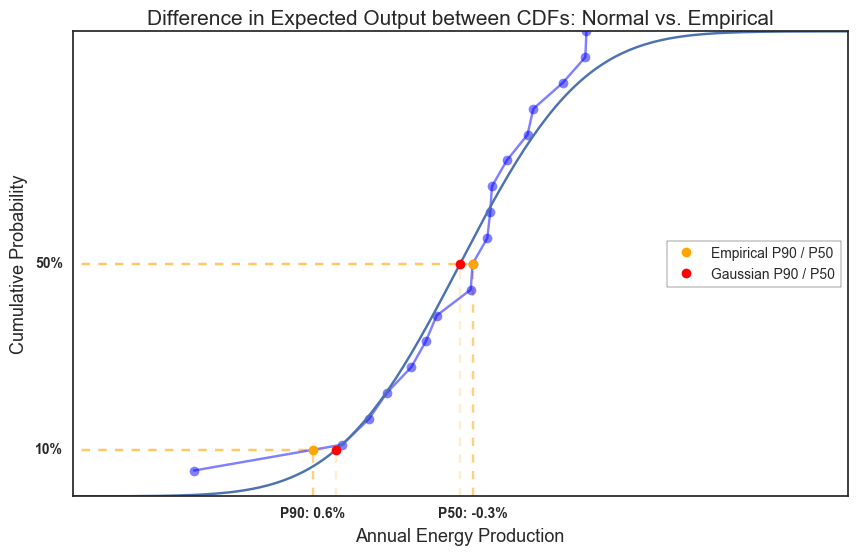

In [30]:
# Create Figure and Axis. 
fig , ax1 = plt.subplots(1,1)
fig.set_size_inches(10,6)

# Empirical
# ----------------------------------------------------------------------------------------

#Plot Empirical Probability 
ax1.plot(x_empirical, y_empirical, '-bo', c = 'BLUE', alpha=0.5)
y_interp = interp1d(x = df_empirical['cumsum'], y = df_empirical['Energy Output [GWh]'])

#Define P10-P50-P90 values
P90 = float(y_interp(0.1))
P50 = float(y_interp(0.5))

PX_empirical = [P90, P50]

#PLOT points over PX Values.

ax1.plot(PX_empirical,[0.1, 0.5], 'o', c= 'orange', label = 'Empirical P90 / P50')

#Plot P50-P90-P10 as vertical curve
ax1.vlines(x = P50, ymin=0, ymax=0.5, linestyles='--', colors='orange', alpha = 0.5)
ax1.vlines(x = P90, ymin=0, ymax = 0.1, linestyles='--', colors='orange', alpha = 0.5)

#Plot P50-P90-P10 as horizontal curve
ax1.hlines(y = 0.5, xmin=0, xmax= P50, linestyles='--', colors='orange', alpha = 0.5)
ax1.hlines(y = 0.1, xmin=0, xmax = P90, linestyles='--', colors='orange', alpha = 0.5)

#------------------------------------------------------------------------------------------

#Gaussian---------------------------------------------------------------------------------

#Plot Gaussian Probability Density Function 
ax1.plot(x1, y_cdf)

#Define P10-P50-P90 values
P90 = normal.ppf(0.1)
P50 = normal.ppf(0.5)

PX_gaussian = [P90, P50]

#PLOT POINTS TO IDENTIFY P-VALUES
ax1.plot(PX_gaussian,[0.1, 0.5], 'o', c= 'red', label = 'Gaussian P90 / P50')

#Plot sample P-values for intructional purposes.
pvals = [(P90,'P90'), (P50,'P50')]
x_ticks = [x for (x,_) in pvals]
x_labels = ['{0}: {1:0.1f}'.format(pvals[i][1],pvals[i][0]) for i, _ in enumerate(pvals)]

y_ticks = [0.1, 0.5]
y_labels = ['{0:.0%}'.format(_) for _ in y_ticks]


#Plot P50-P90-P10 as vertical curve
ax1.vlines(x = loc1, ymin=0, ymax=normal.cdf(loc1), linestyles='--', colors='orange', alpha = 0.2)
ax1.vlines(x = P90, ymin=0, ymax = normal.cdf(P90), linestyles='--', colors='orange', alpha = 0.2)

#Plot P50-P90-P10 as horizontal curve
ax1.hlines(y = normal.cdf(loc1), xmin=0, xmax=loc1, linestyles='--', colors='orange', alpha = 0.2)
ax1.hlines(y = normal.cdf(P90), xmin=0, xmax = P90, linestyles='--', colors='orange', alpha = 0.2)

#--------------------------------------------------------------------------------

#Define the xrange to show for formatting.
plt.xlim(x_min, x_max)
plt.ylim(0,1)
plt.ylabel('Cumulative Probability', fontsize=13)
plt.title('Difference in Expected Output between CDFs: Normal vs. Empirical', fontsize = 15)
plt.xlabel('Annual Energy Production', fontsize=13)

#Set y ticks for P90 and P50
y_ticks = [0.1, 0.5]
y_labels = ['{0:.0%}'.format(_) for _ in y_ticks]

#Set x ticks as the difference between empirical and gaussian.
x_ticks = [x for (x,_) in empirical_pvals]
x_labels = ['P90: {0:.1%}'.format(PX_gaussian[0]/ PX_empirical[0] -1),'P50: {0:.1%}'.format(PX_gaussian[1]/ PX_empirical[1] -1) ]

#Draw ticks
plt.xticks(x_ticks, x_labels, weight = 'bold')
plt.yticks(y_ticks, y_labels, weight = 'bold')

#Show Labels
plt.legend(fontsize = 10, loc =5, frameon=True)

### So what?

The plot exposes the empirical distribution of an 18-year irradiance dataset deviates at various sections when compared to the calculated normal distribution. For example, the P90 and P10 values calculated using the normal CDF are more optimistic than the empirical CDF by 0.6% and 0.4%, respetively. 

In other words, the dataset does not fit to the normal distribution very closely suggesting the empirical methodology yields more reliable results and better estimates of the true P values, given the dataset be sufficiently large for linear interpolation.